In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import scipy.misc as mis
from skimage.transform import resize
from skimage import data
from sklearn import metrics

%matplotlib inline

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])
train_set_x_flatten = np.concatenate((train_set_x_flatten.T, test_set_x_flatten.T), axis=0).T
train_set_y = np.concatenate((train_set_y,test_set_y),axis=1)
num_px = train_set_x_orig.shape[1]
print(train_set_x_flatten.shape)

(12288, 259)


In [7]:
#define the sigmoid activation function for output layer
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [8]:
#initialize the parameters for 2 hidden layers
def initialize_parameters(n_x, n_h1, n_h2, n_y):
  
  #We do random assignment to parameters instead of zero
  W1 = np.random.randn(n_h1, n_x)
  b1 = np.random.randn(n_h1, 1)
  W2 = np.random.randn(n_h2, n_h1)
  b2 = np.random.randn(n_h2, 1)
  W3 = np.random.randn(n_y, n_h2)
  b3 = np.random.randn(n_y, 1)
    
  parameters = {
    "W1": W1,
    "b1" : b1,
    "W2": W2,
    "b2" : b2,
    "W3": W3,
    "b3" : b3
  }
  return parameters

In [9]:
#perform forward propagation
def forward_prop(X, parameters):
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
    
  #b is resized by broadcasting

  #tanh is used as activation ftn for hidden layers and sigmoid for output layer
  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = np.tanh(Z2)    
  Z3 = np.dot(W3, A2) + b3
  A3 = sigmoid(Z3)
  
  #cache is used in back propagation
  cache = {
    "A1": A1,
    "A2": A2,
    "A3": A3  
  }
  return A3, cache

In [10]:
#determine the loss function to retune the parameters
def calculate_cost(A3, Y):
    
  #cost ftn of logisitic regression
  cost = -np.sum(np.multiply(Y, np.log(A3)) +  np.multiply(1-Y, np.log(1-A3)))/m
  cost = np.squeeze(cost)

  return cost

In [11]:
#perform back propagation
def backward_prop(X, Y, cache, parameters):
  A1 = cache["A1"]
  A2 = cache["A2"]
  A3 = cache["A3"]

  W3 = parameters["W3"]
  W2 = parameters["W2"]

  #backpropagation for output layer
  dZ3 = A3 - Y
  dW3 = np.dot(dZ3, A2.T)/m
  db3 = np.sum(dZ3, axis=1, keepdims=True)/m

  #backpropagation for 2nd hidden layer
  dZ2 = np.multiply(np.dot(W3.T, dZ3), 1-np.power(A2, 2))
  dW2 = np.dot(dZ2, A1.T)/m
  db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    
  #backpropagation for 1st hidden layer 
  dZ1 = np.multiply(np.dot(W2.T, dZ2), 1-np.power(A1, 2))
  dW1 = np.dot(dZ1, X.T)/m
  db1 = np.sum(dZ1, axis=1, keepdims=True)/m

  grads = {
    "dW1": dW1,
    "db1": db1,
    "dW2": dW2,
    "db2": db2,
    "dW3": dW3,
    "db3": db3
  }

  return grads

In [12]:
#We update the parameters
def update_parameters(parameters, grads, learning_rate):
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
    
  dW1 = grads["dW1"]
  db1 = grads["db1"]
  dW2 = grads["dW2"]
  db2 = grads["db2"]
  dW3 = grads["dW3"]
  db3 = grads["db3"]
    
  #performing gradient descenet
  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2
  W3 = W3 - learning_rate * dW3
  b3 = b3 - learning_rate * db3

  new_parameters = {
    "W1": W1,
    "W2": W2,
    "W3": W3,
    "b1" : b1,
    "b2" : b2,
    "b3" : b3
  }

  return new_parameters

In [13]:
#model to run neural network
def model(X, Y, n_x, n_h1, n_h2, n_y, num_of_iters, learning_rate):
  parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)

  interval = np.array([])
  cost_to_interval = np.array([])

  #Running the model for a number of iterations
  for i in range(0, num_of_iters+1):
    a2, cache = forward_prop(X, parameters)

    cost = calculate_cost(a2, Y)

    grads = backward_prop(X, Y, cache, parameters)

    parameters = update_parameters(parameters, grads, learning_rate)
    if (i > 100):
        interval = np.append (interval, [int(i)])
        cost_to_interval = np.append (cost_to_interval, [int(cost)])
        
    if(i % 100 == 0):
      print('Cost after iteration# {:d}: {:f}'.format(i, cost))
    
  plt.plot(interval,cost_to_interval)
    
  return parameters

In [14]:
#model for prediction
def predict(X, parameters):
  a2, cache = forward_prop(X, parameters)
  yhat = a2
  yhat = np.squeeze(yhat)

  #If prediction is more than 0.5 we classify as 1 otherwise as 0
  if(yhat >= 0.5):
    y_predict = 1
  else:
    y_predict = 0

  return y_predict

Cost after iteration# 0: 2.697909
Cost after iteration# 100: 0.295568
Cost after iteration# 200: 0.147889
Cost after iteration# 300: 0.089082
Cost after iteration# 400: 0.066807
Cost after iteration# 500: 0.049807
Cost after iteration# 600: 0.043569
Cost after iteration# 700: 0.035952
Cost after iteration# 800: 0.030754
Cost after iteration# 900: 0.027895
Cost after iteration# 1000: 0.024794
Cost after iteration# 1100: 0.022395
Cost after iteration# 1200: 0.020275
Cost after iteration# 1300: 0.018662
Cost after iteration# 1400: 0.017430
Cost after iteration# 1500: 0.016306
Cost after iteration# 1600: 0.015159
Cost after iteration# 1700: 0.013979
Cost after iteration# 1800: 0.013079
Cost after iteration# 1900: 0.011687
Cost after iteration# 2000: 0.010834
Cost after iteration# 2100: 0.010191
Cost after iteration# 2200: 0.009627
Cost after iteration# 2300: 0.008983
Cost after iteration# 2400: 0.008015
Cost after iteration# 2500: 0.007502
Cost after iteration# 2600: 0.007068
Cost after it

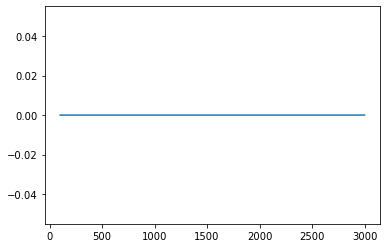

In [15]:
#main code starts here
if __name__ == "__main__":
    np.random.seed(2)

    X = train_set_x_flatten
    Y = train_set_y
    
    m = X.shape[1]

    # Set the hyperparameters
    n_x = 12288      #No. of neurons in first layer
    n_h1 = 256    #No. of neurons in 1st hidden layer
    n_h2 = 32     #No. of neurons in 2nd hidden layer
    n_y = 1      #No. of neurons in output layer
    num_of_iters = 3000
    learning_rate = 0.6
    
    trained_parameters = model(X, Y, n_x, n_h1, n_h2, n_y, num_of_iters, learning_rate)

In [16]:
total = 0
sum = 0
for i in range(len(train_set_x_flatten.T)):
    y_predict = predict(train_set_x_flatten.T[i].reshape((train_set_x_flatten.shape[0]),1), trained_parameters)
    y_hat = train_set_y.T[i][0]
    if (y_predict == y_hat):
        sum = sum + 1
    total = total + 1
print('Train set accuracy is {:f}'.format(sum*100/total))

Train set accuracy is 100.000000


In [17]:
predicted = np.array([])
actual = np.array([])

for i in range(1,51):
    my_image = "test" + str(i) + ".jpg"
    fname = "images/" + my_image
    img= Image.open(fname)
    np_img = np.array(img)
    image = np_img/255.
    my_image = resize(image, (num_px,num_px)).reshape((num_px*num_px*3,1))
    y_predict = int(predict(my_image, trained_parameters))
    y_hat = 0
    if (i < 26):
        y_hat = 1

    predicted = np.append (predicted, [int(y_predict)])
    actual = np.append (actual, [int(y_hat)])
    

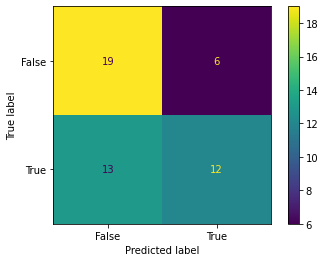

In [18]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
cm_display.plot()
plt.show()

In [1]:
my_image = "cat5.jpg"
fname = "images/" + my_image

img= Image.open(fname)
np_img = np.array(img)
image = np_img/255.
my_image = resize(image, (num_px,num_px)).reshape((num_px*num_px*3,1))
y_predict = int(predict(my_image, trained_parameters))
if (y_predict == 1):
    print('Neural Network prediction is "Cat"')
else:
    print('Neural Network prediction is "Non-Cat"')

plt.imshow(image)

NameError: name 'Image' is not defined